In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from SALib.analyze import sobol
import warnings
from ema_workbench.analysis import feature_scoring
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
import ema_workbench.em_framework.optimization
from ema_workbench.em_framework.optimization import to_problem, epsilon_nondominated, EpsilonProgress, ArchiveLogger, GenerationalDistanceMetric,  EpsilonIndicatorMetric, InvertedGenerationalDistanceMetric, SpacingMetric
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers,
)


from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.analysis import prim
from ema_workbench.em_framework.parameters import Constant
import pickle
warnings.filterwarnings("ignore")
ema_logging.log_to_stderr(ema_logging.INFO)


<Logger EMA (DEBUG)>

## Delft Blue Incoming Files

In [2]:
# Model
dike_model, planning_steps = get_model_for_problem_formulation(2)

In [3]:
# Load results from DB
scenario_results = []
scenario_convergence = []
seeds = [27097, 567] # 45646, 90, 676465]  # seeds used un DB - to change later
for seed in seeds:
    df = pd.read_csv(f"output/results_seed_{seed}.csv")
    df_c = pd.read_csv(f"output/convergence_seed_{seed}.csv")
    scenario_results.append(df)
    scenario_convergence.append(df_c)
    l = df.columns.tolist()

In [4]:
# Load archive
archive_results = []
seeds = [27097, 567] # 45646, 90, 676465]  # seeds used un DB - to change later
for seed in seeds:
   archives = ArchiveLogger.load_archives(f"output/seed_{seed}_archive.tar.gz")  # Use '/'
   #for key in archives.keys():
   archive_results.append(archives)

In [5]:
pol = []
for policy in dike_model.levers:
    pol.append(policy)

for outcome in dike_model.outcomes:
    pol.append(outcome)

len(pol)
dike_model_problem =dike_model
dike_model_problem.outcomes

## Merge Seeds

In [6]:
for archive in archive_results:
    for key, df in archive.items():
        for col in dike_model.levers:
            if col.name not in df.columns:
                df[col.name] = 0

In [7]:
#Make sure that the results contain all policies (rest is set to 0)
for df in scenario_results:
    for col in dike_model.levers:
        if col.name not in df.columns:
            df[col.name] = 0

In [8]:
#Rename problem levers and outcomes to compatible name format

for lever in dike_model_problem.levers:
    lever.name = 'L_' + lever.name.replace(" ", "_").replace(".", "_")

for outcome in dike_model_problem.outcomes:
    outcome.name = 'L_' + outcome.name.replace(" ", "_").replace(".", "_")

In [9]:
#Defining the problem
problem = to_problem(dike_model_problem, searchover="levers")

In [10]:
#Rename the scenario levers and outcomes

def clean_names(name_list):
    return ['L_' + name.replace(" ", "_").replace(".", "_") for name in name_list]

# Clean column names in the scenario results
for i in range(len(scenario_results)):
    scenario_results[i].columns = clean_names(scenario_results[i].columns)

In [11]:
#Merge the results from the different seeds for each of the two scenarios
epsilons = [0.05] * len(dike_model.outcomes)

#Merge the list of results into a single set of non dominated results using the provided epsilon values
merged_results = epsilon_nondominated(scenario_results,epsilons,problem)

## Convergence Metrics

In [12]:
gen_dis = GenerationalDistanceMetric(merged_results, problem, d=1)
e_ind = EpsilonIndicatorMetric(merged_results, problem)
i_gen = InvertedGenerationalDistanceMetric(merged_results, problem, d=1)
s_met = SpacingMetric(problem)

In [13]:
metrics_by_seed = []
for archives in archive_results:
    metrics = []
    for nfe, archive in archives.items():
        archive.columns=clean_names(archive.columns)
        if int(nfe) == 0:
            continue
        scores = {
            "generational_distance": gen_dis.calculate(archive),
            "epsilon_indicator": e_ind.calculate(archive),
            "inverted_gd": i_gen.calculate(archive),
            "spacing": s_met.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    metrics_by_seed.append(metrics)

## Plots

NameError: name 'scenario_0_convergences' is not defined

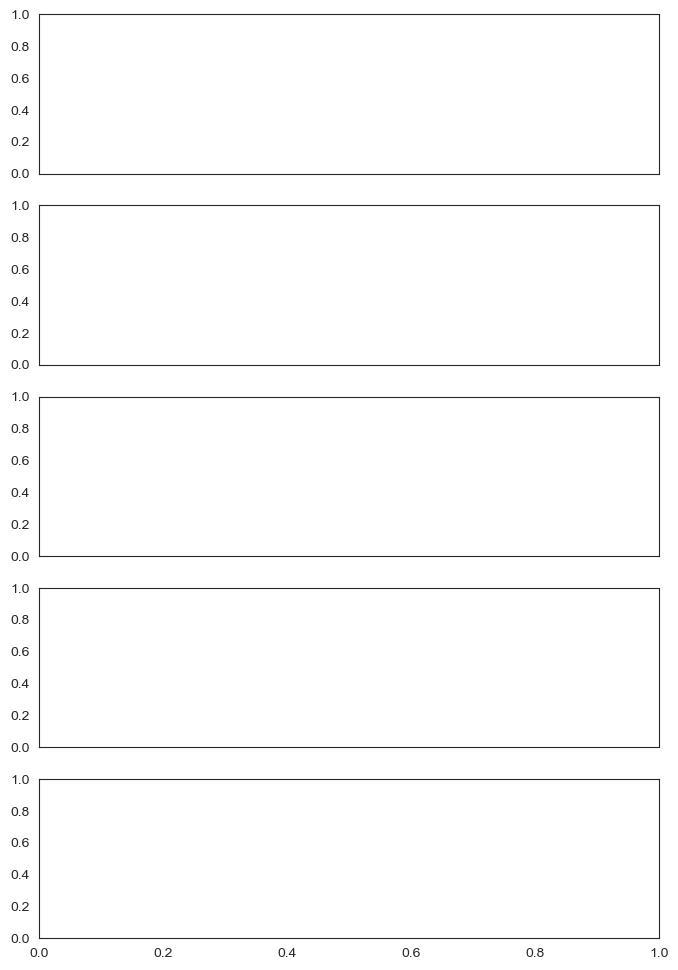

In [14]:
sns.set_style("white")

fig, axes = plt.subplots(nrows=5, figsize=(8, 12), sharex=True)

ax2, ax3, ax4, ax5, ax6 = axes

for metrics, convergence in zip(metrics_by_seed, scenario_0_convergences):

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")

    ax3.plot(metrics.nfe, metrics.generational_distance)
    ax3.set_ylabel("generational distance")

    ax4.plot(metrics.nfe, metrics.epsilon_indicator)
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metrics.nfe, metrics.inverted_gd)
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metrics.nfe, metrics.spacing)
    ax6.set_ylabel("spacing")

ax6.set_xlabel("nfe")

sns.despine(fig)

fig.suptitle('Convergence Metrics Scenario 0')



plt.show()